In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import mean_squared_error
import graphviz
import datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import seaborn as sns

from pathlib import Path
from shiny import App, render, ui
Path("shiny_decisiontree").mkdir(parents = True, exist_ok = True)
Path("shiny_eda").mkdir(parents = True, exist_ok = True)

In [20]:
# /Users/jonathankang/Documents/College/FA22/STAT 430
# data = pd.read_csv("chicago_crimes_2019-present.csv", sep=";")
url = "https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD"
original_data = pd.read_csv(url)
reduced_data = original_data[(original_data["Year"] == 2019) |
                             (original_data["Year"] == 2020) |
                             (original_data["Year"] == 2021) |
                             (original_data["Year"] == 2022) ]
data = reduced_data.copy() 
# data.head()

In [21]:
data.count()

ID                      900129
Case Number             900129
Date                    900129
Block                   900129
IUCR                    900129
Primary Type            900129
Description             900129
Location Description    896127
Arrest                  900129
Domestic                900129
Beat                    900129
District                900129
Ward                    900084
Community Area          900128
FBI Code                900129
X Coordinate            888036
Y Coordinate            888036
Year                    900129
Updated On              900129
Latitude                888036
Longitude               888036
Location                888036
dtype: int64

In [22]:
len(data.columns)

22

In [23]:
data_locations = data[["ID", "Case Number", "Block", "Location Description", "Beat", "District", "Ward", "Community Area"]]
data_locations = data_locations.dropna().astype({'Community Area': int})
data_locations.head()
data_locations.count()

ID                      896083
Case Number             896083
Block                   896083
Location Description    896083
Beat                    896083
District                896083
Ward                    896083
Community Area          896083
dtype: int64

### Build graph for Location Descriptions

<BarContainer object of 14 artists>

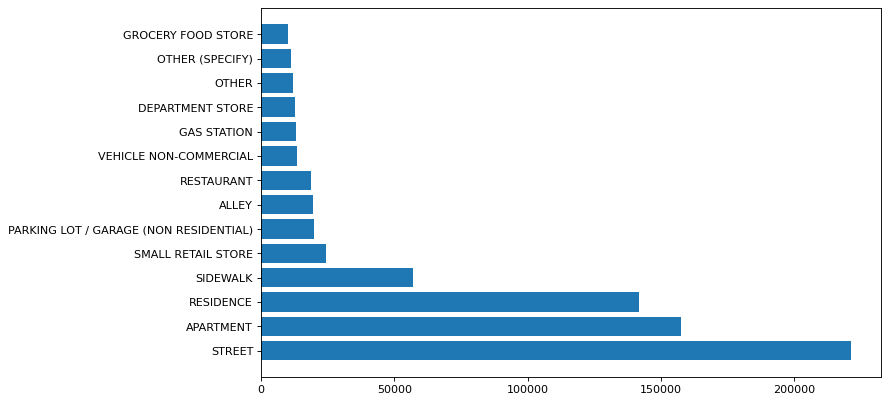

In [24]:
data_locdesc = data_locations["Location Description"]
data_loc_counts = data_locations["Location Description"].value_counts()
data_loc_majors = data_loc_counts[data_loc_counts > 10000]

xs = data_loc_majors.index.tolist()
plt.figure(figsize=(10, 6), dpi=80)
plt.barh(xs, data_loc_majors)

In [25]:
# Numericals
data_loc_counts.describe()

count       184.000000
mean       4870.016304
std       22919.120524
min           1.000000
25%          25.000000
50%         250.500000
75%        1202.250000
max      221382.000000
Name: Location Description, dtype: float64

### Build graph for Districts

In [26]:
# district_data = pd.read_csv("https://datahub.cmap.illinois.gov/dataset/1d2dd970-f0a6-4736-96a1-3caeb431f5e4/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e/download/ReferenceCCAProfiles20162020.csv")[["GEOID",'GEOG']]
district_data = pd.read_csv("https://gist.githubusercontent.com/JasonMcGregor/d2aacb2205851d2426dd/raw/b356837c0c5fc0688164d6efabd4b96756175e44/ChicagoSocEconIndicators2008_12.csv")
district_data = district_data[["Community Area Number", "COMMUNITY AREA NAME"]]
district_data = district_data.rename(columns = {'Community Area Number':'Community Area', "COMMUNITY AREA NAME":"Community Area Name"})
district_data.head(3) 
# district_data


,Community Area,Community Area Name
0,1.0,Rogers Park
1,2.0,West Ridge
2,3.0,Uptown


In [27]:
# data_locations
data_comm = pd.merge(data_locations, district_data, how='left', on='Community Area')
data_comm = data_comm[["Community Area Name"]]
data_comm_counts = data_comm.value_counts()[0:10]
# data_comm_counts
data_comm.value_counts()

Community Area Name
Austin                 50424
Near North Side        37804
South Shore            31510
Near West Side         31296
North Lawndale         28801
                       ...  
Hegewisch               2182
Forest Glen             2015
Mount Greenwood         1974
Burnside                1349
Edison Park             1039
Length: 77, dtype: int64

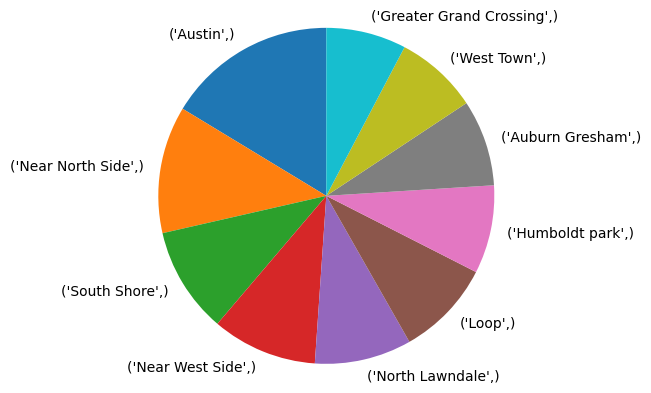

In [28]:
labels = data_comm_counts.index.to_list()
fig1, ax1 = plt.subplots()
ax1.pie(data_comm_counts, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Graph for distribution of when crimes occurred

In [29]:
time_crime = data.copy()
time_crime["Date"] = pd.to_datetime(time_crime["Date"])
time_crime["Time"] = ((time_crime["Date"].dt.time).astype(str).str.replace(":","")).astype(int)
time_crime_counts = time_crime.groupby("Time").count().reset_index(drop=False)[["Time", "ID"]]

[Text(0.5, 1.0, 'Distribution of Time When Crimes Happened')]

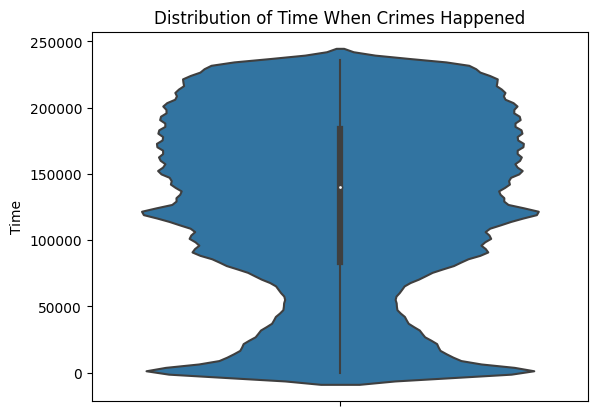

In [30]:
# time_crime
sns.violinplot(y=time_crime["Time"]).set(title='Distribution of Time When Crimes Happened')
# sns.displot(time_crime, x="Time")

In [31]:
time_crime["Time"].value_counts().sort_values()[::-1].head()

0         26450
120000    23450
90000     18391
170000    15410
180000    15321
Name: Time, dtype: int64

## Models
Given day of the week, time of the day, and location description, can we predict the likeliness of a violent crime occurring? 

Goal:  
Can we identify the type of crime given location, location description, day of week, and time of day?  
Supervised learning method - decision tree model

1) Categorize crimes to [Crimes Against a Person (includes Assault/Homicide, Rape/Sexual Assault, and Misc), and Other Criminal Activity] - Main focus will be on the type of crime to happen to a person
(https://www.justia.com/criminal/offenses/)

For related works: (https://open.lib.umn.edu/socialproblems/chapter/8-2-types-of-crime/)

2) Build:  
model A: Determine clarity of criminal categorization based on: [Date(Day of Week), Date(Time), Location Description, Community Area].   

3) Compare accuracy and effectiveness -> Determine which criminal categorization is the best.  
Maybe can even make a Shiny app?

In [32]:
model_data = data.copy()
model_data["CrimeCategories"] = 0
# AssaultHomicide = ["BATTERY", "ASSAULT", 'ARSON', 'HOMICIDE']
# SexualOffense = ['CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'PROSTITUTION', 'SEX OFFENSE', 'PUBLIC INDECENCY']
# Misc = ['THEFT','ROBBERY','BURGLARY','STALKING','KIDNAPPING','INTIMIDATION']

CrimesAgainstPerson = ["BATTERY", "ASSAULT", 'ARSON', 'HOMICIDE','CRIM SEXUAL ASSAULT',
                        'CRIMINAL SEXUAL ASSAULT', 'PROSTITUTION', 'SEX OFFENSE', 'PUBLIC INDECENCY',
                        'THEFT','ROBBERY','BURGLARY','STALKING','KIDNAPPING','INTIMIDATION']

# 1 = Assault, 2 = Sexual Offenses, 3 = Miscs, 0 = others
# model_data.loc[model_data['Primary Type'].isin(AssaultHomicide),"CrimeCategories"] = 1
# model_data.loc[model_data['Primary Type'].isin(SexualOffense),"CrimeCategories"] = 2
# model_data.loc[model_data['Primary Type'].isin(Misc),"CrimeCategories"] = 3

model_data.loc[model_data['Primary Type'].isin(CrimesAgainstPerson),"CrimeCategories"] = 1

# Convert date to datetime format
model_data["Date"] = pd.to_datetime(model_data["Date"])
model_data["Day"] = model_data["Date"].dt.dayofweek

In [33]:
model_data["Day"] = model_data["Date"].dt.dayofweek # 0 = Monday, 6 = Sunday
model_data["Time"] = ((model_data["Date"].dt.time).astype(str).str.replace(":","")).astype(int)
model_data["Year"] = (model_data["Date"].dt.year).astype(int)
model_data = model_data[["ID", "Primary Type", "Description", "Location Description", "Beat", "District",'Ward','Community Area', "CrimeCategories", "Day", "Time", "Year"]]
model_data = model_data.dropna()

In [34]:
# Build Model A
model_A = model_data[["Year", "CrimeCategories", "Day", "Time", "Community Area", "Location Description"]]

model_A = pd.get_dummies(model_A)

In [35]:
model_A_train = model_A[(model_A["Year"] >= 2019) & (model_A["Year"] < 2022)]
model_A_test = model_A[(model_A["Year"] >= 2022)]
model_A_train = model_A_train.drop(columns = ['Year'])
model_A_test = model_A_test.drop(columns = ['Year'])

# model_A_train
X_train = model_A_train.drop(columns = ['CrimeCategories'])
y_train = model_A_train["CrimeCategories"]

X_test = model_A_test.drop(columns = ['CrimeCategories'])
y_test = model_A_test["CrimeCategories"]


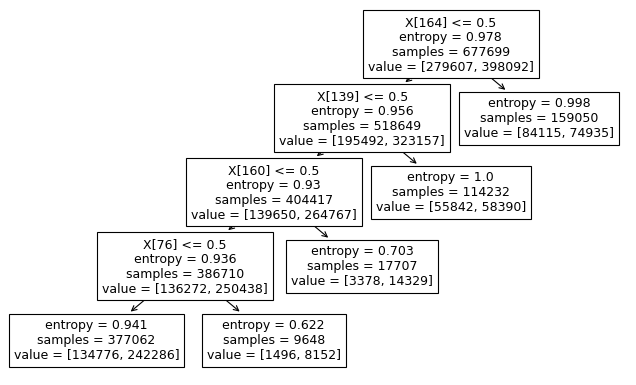

In [36]:
# X_train = pd.get_dummies(X_train)
## Sample Model with 5 leaves
dtree = tree.DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=5)
dtree.fit(X_train, y_train)

plt.figure(figsize=(10, 6), dpi=80)
tree.plot_tree(dtree)
plt.show()

In [37]:
y_pred = dtree.predict(X_test)

In [38]:
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",accuracy)

Accuracy: 0.6139323393655213


In [39]:
# Pruning step - find params for highest accuracy
best_acc = 0

for crit in "gini", "entropy":
    print("criterion: ", crit)
    for max_depth in range(11,14): # also tested for 2:11. reduced to this to shorten runtime
        print("depth: ", max_depth)
        for min_samples_leaf in [5, 10, 20]:
            print("samples_leaf: ", min_samples_leaf)
            dtree = tree.DecisionTreeClassifier(max_depth=max_depth,
                                                criterion=crit,
                                                min_samples_leaf=min_samples_leaf)
            dtree.fit(X_train, y_train)
            predicitions = dtree.predict(X_test)
            accuracy = sklearn.metrics.accuracy_score(y_test, predicitions)
            if accuracy > best_acc:
                best_params = f"criterion: {crit}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}"
                best_acc = accuracy

print(best_acc)

criterion:  gini
depth:  11
samples_leaf:  5
samples_leaf:  10
samples_leaf:  20
depth:  12
samples_leaf:  5
samples_leaf:  10
samples_leaf:  20
depth:  13
samples_leaf:  5
samples_leaf:  10
samples_leaf:  20
criterion:  entropy
depth:  11
samples_leaf:  5
samples_leaf:  10
samples_leaf:  20
depth:  12
samples_leaf:  5
samples_leaf:  10
samples_leaf:  20
depth:  13
samples_leaf:  5
samples_leaf:  10
samples_leaf:  20
0.6353624807678219


In [40]:
print(best_params)
# Best: criterion: gini, max_depth: 12, min_samples_leaf: 20

criterion: gini, max_depth: 12, min_samples_leaf: 20


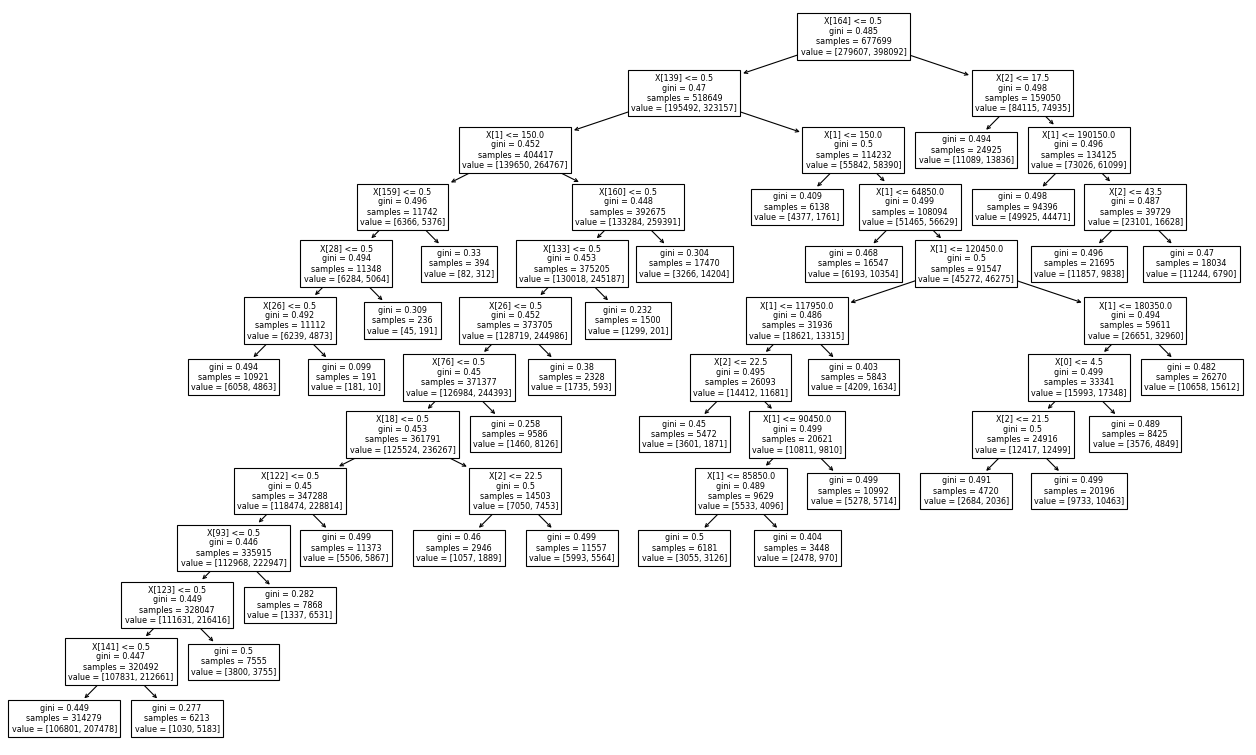

In [41]:
# Use best criteria to build decision tree plot
dtree = tree.DecisionTreeClassifier(criterion="gini", max_leaf_nodes=30, max_depth=12)
dtree.fit(X_train, y_train)
plt.figure(figsize=(20, 12), dpi=80)
tree.plot_tree(dtree)
plt.show()

With this decision tree model, our model accuracy with the test data is 61.39%

## Model 2

**Time Series - Exponential Smoothing Model**  
1.  Find the counts of crimes on the daily basis.  
2.  Holt's Exponential Smoothing - considered an ETS model as it models for error, trend, season.
3.  Evaluate Accuracy by checking RMSE.  

In [42]:
model_data_B = data.copy()
model_data_B["Date"] = pd.to_datetime(model_data_B["Date"])

In [43]:
TS_data = model_data_B.copy()
TS_data = TS_data.dropna()
TS_data["Date"] = TS_data["Date"].dt.date
TS_data = TS_data.groupby("Date").count()["ID"].reset_index(drop=False)
TS_data


,Date,ID
0,2019-01-01,1007
1,2019-01-02,644
2,2019-01-03,748
3,2019-01-04,760
4,2019-01-05,789
...,...,...
1430,2022-12-01,598
1431,2022-12-02,704
1432,2022-12-03,594
1433,2022-12-04,626


Text(0, 0.5, 'Counts')

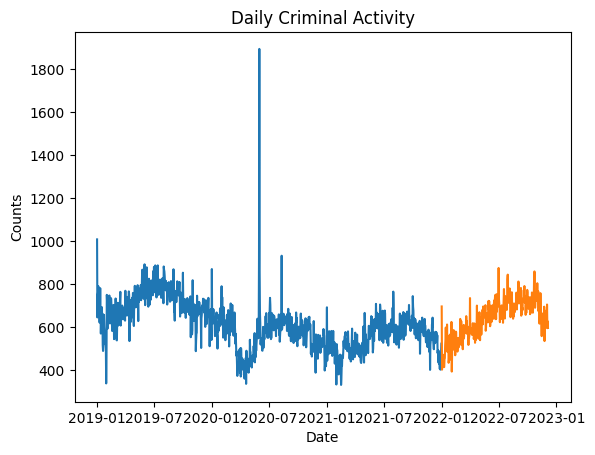

In [44]:
TS_data = TS_data.rename(columns = {"ID" : "Counts"})

TS_data_train = TS_data[(TS_data["Date"] >= datetime.date(2019, 1, 1)) & (TS_data["Date"] < datetime.date(2022, 1, 1))]
TS_data_test = TS_data[(TS_data["Date"] >= datetime.date(2022, 1, 1))]

TS_X_train = TS_data_train["Date"]
TS_Y_train = TS_data_train["Counts"]
TS_X_test = TS_data_test["Date"]
TS_Y_test = TS_data_test["Counts"]

plt.plot(TS_X_train, TS_Y_train)
plt.plot(TS_X_test, TS_Y_test)
plt.title("Daily Criminal Activity")
plt.xlabel("Date")
plt.ylabel("Counts")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Text(0, 0.5, 'Counts')

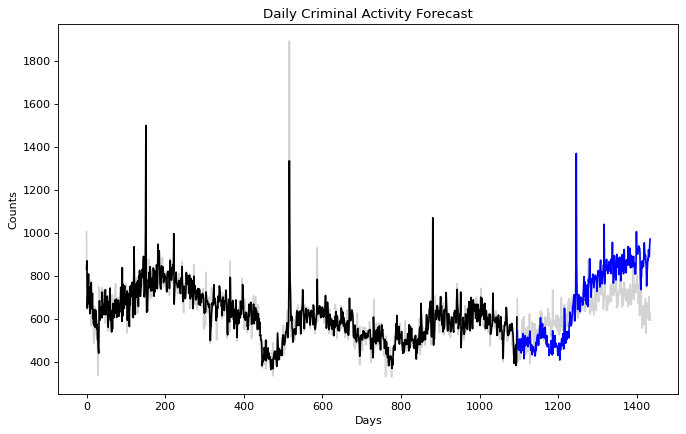

In [46]:
ts_fit = ExponentialSmoothing(
    TS_Y_train,
    seasonal_periods = 365,
    trend="mul",
    seasonal="mul",
    damped_trend=False,
    initialization_method="estimated",
).fit()

plt.figure(figsize=(10, 6), dpi=80)

ts_forecast = ts_fit.forecast(len(TS_Y_test)) 

plt.plot(TS_Y_train, color = "lightgrey")
plt.plot(TS_Y_test, color = "lightgrey")
plt.plot(ts_fit.fittedvalues, color="black", ls = '-')
plt.plot(ts_forecast, color="blue", ls = '-')
plt.title("Daily Criminal Activity Forecast")
plt.xlabel("Days")
plt.ylabel("Counts")

In [56]:
best_day = 0
best_result = [10000,10000] #[RMSE, NRMSE]
best_ts_forecast = 0
best_ts_sample = 0

results = np.zeros((298,2))

for n in range(2,300):
  if n%20 == 0:
    print(n)
  days = n
  ts_forecast_sample = ts_fit.forecast(days) 
  TS_Y_test_subset = TS_Y_test.iloc[:days]
  
  MSE = mean_squared_error(TS_Y_test_subset, ts_forecast_sample)
  RMSE = np.sqrt(MSE)
  NRMSE = RMSE/np.mean(TS_Y_test_subset)

  if NRMSE < best_result[1]:
    best_day = n
    best_result = [RMSE, NRMSE]
    best_ts_forecast = ts_forecast_sample
    best_ts_sample = TS_Y_test_subset
  results[n-2] = np.array([RMSE, NRMSE])
  
print(best_day, best_result)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
31 [62.90533059705299, 0.12779770945072694]


Text(0, 0.5, 'Counts')

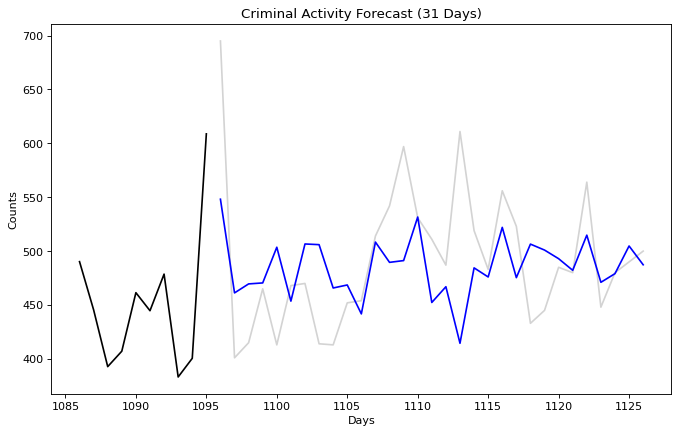

In [57]:
plt.figure(figsize=(10, 6), dpi=80)

plt.plot(best_ts_sample, color = "lightgrey")
plt.plot(ts_fit.fittedvalues[-10:], color="black", ls = '-')
plt.plot(best_ts_forecast, color="blue", ls = '-')

plt.title("Criminal Activity Forecast (31 Days)")
plt.xlabel("Days")
plt.ylabel("Counts")

The best prediction range: 31 days.  
With an RMSE = 62.905 and Normalized RMSE = 0.128.  





Text(0, 0.5, 'NRMSE Score')

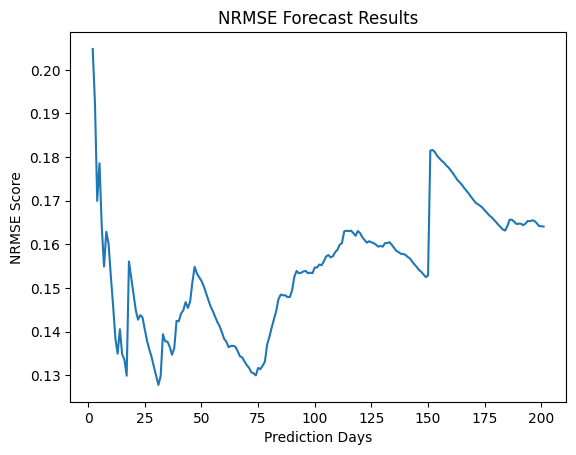

In [58]:
xs = np.linspace(2, 299, num=298)
ys = results[:,1]

plt.plot(xs[:200], ys[:200])
plt.title("NRMSE Forecast Results")
plt.xlabel("Prediction Days")
plt.ylabel("NRMSE Score")

# Creating the Shiny

In [210]:
%%writefile shiny_decisiontree/app.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import mean_squared_error
import graphviz
import datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import seaborn as sns
from pathlib import Path
from shiny import *

###
# Input
url = "https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD"
original_data = pd.read_csv(url)
reduced_data = original_data[(original_data["Year"] == 2019) |
                             (original_data["Year"] == 2020) |
                             (original_data["Year"] == 2021) |
                             (original_data["Year"] == 2022) ]
data = reduced_data.copy() 
model_data = data.copy()
model_data["CrimeCategories"] = 0
CrimesAgainstPerson = ["BATTERY", "ASSAULT", 'ARSON', 'HOMICIDE','CRIM SEXUAL ASSAULT',
                        'CRIMINAL SEXUAL ASSAULT', 'PROSTITUTION', 'SEX OFFENSE', 'PUBLIC INDECENCY',
                        'THEFT','ROBBERY','BURGLARY','STALKING','KIDNAPPING','INTIMIDATION']
model_data.loc[model_data['Primary Type'].isin(CrimesAgainstPerson),"CrimeCategories"] = 1
# Convert date to datetime format
model_data["Date"] = pd.to_datetime(model_data["Date"])
model_data["Day"] = model_data["Date"].dt.dayofweek
model_data["Day"] = model_data["Date"].dt.dayofweek # 0 = Monday, 6 = Sunday
model_data["Time"] = ((model_data["Date"].dt.time).astype(str).str.replace(":","")).astype(int)
model_data["Year"] = (model_data["Date"].dt.year).astype(int)
model_data = model_data[["ID", "Primary Type", "Description", "Location Description", "Beat", "District",'Ward','Community Area', "CrimeCategories", "Day", "Time", "Year"]]
model_data = model_data.dropna()
# Build Model A
model_A = model_data[["Year", "CrimeCategories", "Day", "Time", "Community Area", "Location Description"]]
model_A = pd.get_dummies(model_A)
model_A_train = model_A[(model_A["Year"] >= 2019) & (model_A["Year"] < 2022)]
model_A_test = model_A[(model_A["Year"] >= 2022)]
model_A_train = model_A_train.drop(columns = ['Year'])
model_A_test = model_A_test.drop(columns = ['Year'])
# model_A_train
X_train = model_A_train.drop(columns = ['CrimeCategories'])
y_train = model_A_train["CrimeCategories"]
X_test = model_A_test.drop(columns = ['CrimeCategories'])
y_test = model_A_test["CrimeCategories"]
# Build tree
dtree = tree.DecisionTreeClassifier(criterion="gini", max_leaf_nodes=30, max_depth=12)
dtree.fit(X_train, y_train)

# y_pred = dtree.predict(X_test)
###

app_ui = ui.page_fluid(
  ui.h2("Decision Tree Result! v2"),
  ui.input_slider("day", "Day of the Week (0 = Monday, 6 = Sunday)", 0, 6, 0), # Day (0-6) Slider
  ui.input_numeric("time", "Time of Criminal Activity (0 - 235959)", 120000), # Time (0 - 235959) Input
  ui.input_numeric("area", "Community Area (1.0 - 77.0)", 1.0), # Community Area (1.0 - 77.0) Input
  
  ui.input_select(
          "loc_desc",
          "Choose a Location Description:",
          choices = pd.Series(X_test.columns[X_test.columns.str.contains("Location")])
        ),

  # ui.output_text_verbatim("txt"),
  ui.output_text_verbatim("loc_desc_output"),
  ui.input_action_button("run", "Run Prediction", class_="btn-success"),
  ui.output_text_verbatim("pred_result"),
  # ui.output_plot("plot")
  
)

# Part 2: server ----
def server(input, output, session):
  # @output
  # @render.text
  # @reactive.event(lambda: input.run(), ignore_none=False)
  # def txt():
  #   return f"Day is {input.day()}"
  
  @output
  @render.text
  # @reactive.event(lambda: input.run(), ignore_none=False)
  def loc_desc_output():
    return f"Location Description Chosen: {input.loc_desc()}"

  # @output
  # @render.text
  # @reactive.event(lambda: input.run(), ignore_none=False)
  # def plot():
  #   # fig, ax = plt.subplots()
  #   # ax.figure(figsize=(20, 12), dpi=80)
  #   tree.plot_tree(dtree)
  #   pass
  
  @output
  @render.text
  @reactive.event(lambda: input.run(), ignore_none=False)
  def pred_result():
    temp = X_test.head(1).reset_index(drop=True)
    for col in temp.columns:
      temp[col].values[:] = 0
    temp["Day"] = int(input.day())
    temp["Time"] = int(input.time())
    temp["Community Area"] = float(input.area())
    description = int(input.loc_desc())
    temp.iloc[:,description + 3] = 1
    # display(temp)
    prediction_result = int(dtree.predict(temp))
    # prediction_result
    if prediction_result == 1:
      return f"Result = 1. It is likely that the crime will be a Crime Against a Person"
    else:
      return f"Result = 0. It is unlikely that the crime will be a Crime Against a Person"  

  # Receive User Input

# Combine into a shiny app.
# This is a shiny.App object. 
# Note: that the variable must be "app".
app = App(app_ui, server)

Overwriting shiny_test/app.py


In [211]:
!shiny run --reload shiny_test/app.py
## Takes around 15 minutes to run

INFO:     Will watch for changes in these directories: ['/Users/jonathankang/Downloads/shiny_test']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [64071] using StatReload
INFO:     Started server process [64074]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:53009 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:53009 - "GET /require.min.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:53015 - "GET /shiny.min.css HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:53016 - "GET /jquery-3.6.0.min.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:53017 - "GET /bootstrap.bundle.min.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:53010 - "GET /bootstrap.min.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:53018 - "GET /css/ion.rangeSlider.css HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:53009 - "GET /js/ion.rangeSlider.min.js HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:53016 - "GET

In [8]:
%%writefile shiny_eda/app.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import mean_squared_error
import graphviz
import datetime
import seaborn as sns
from pathlib import Path
from shiny import *

###
# Input
url = "https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD"
original_data = pd.read_csv(url)
reduced_data = original_data[(original_data["Year"] == 2019) |
                             (original_data["Year"] == 2020) |
                             (original_data["Year"] == 2021) |
                             (original_data["Year"] == 2022) ]

## Location Data
data = reduced_data.copy() 
data_locations = data[["ID", "Case Number", "Block", "Location Description", "Beat", "District", "Ward", "Community Area"]]
data_locations = data_locations.dropna().astype({'Community Area': int})
data_locdesc = data_locations["Location Description"]
data_loc_counts = data_locations["Location Description"].value_counts()

## District Data
district_data = pd.read_csv("https://gist.githubusercontent.com/JasonMcGregor/d2aacb2205851d2426dd/raw/b356837c0c5fc0688164d6efabd4b96756175e44/ChicagoSocEconIndicators2008_12.csv")
district_data = district_data[["Community Area Number", "COMMUNITY AREA NAME"]]
district_data = district_data.rename(columns = {'Community Area Number':'Community Area', "COMMUNITY AREA NAME":"Community Area Name"})
data_comm = pd.merge(data_locations, district_data, how='left', on='Community Area')
data_comm = data_comm[["Community Area Name"]]

## Time
TS_data = data.copy()
TS_data["Date"] = pd.to_datetime(TS_data["Date"])
TS_data = TS_data.dropna()
TS_data["Date"] = TS_data["Date"].dt.date
TS_data = TS_data.groupby("Date").count()["ID"].reset_index(drop=False)
TS_data = TS_data.rename(columns = {"ID" : "Counts"})

# TS_interested = TS_data[(TS_data["Date"] >= datetime.date(2019, 1, 1)) &
#                         (TS_data["Date"] < datetime.date(2022, 1, 1))]
# plt.title("Daily Criminal Activity")
# plt.xlabel("Date")
# plt.ylabel("Counts")
###

app_ui = ui.page_fluid(
  ui.h2("Exploratory Graphs"),

  ui.panel_sidebar(
    ui.input_numeric("counts_min", "Crime Counts Minimum:", 1),
    ui.input_numeric("counts_max", "Crime Counts Maximum:", 9999999999),
  ),
  ui.panel_main(
    ui.output_plot("loc_desc_output"),
  ),

  ui.panel_sidebar(
    ui.input_slider("comm_count", "Visible Community Areas", 1, 77, 1),
  ),
  ui.panel_main(
    ui.output_plot("district_output"),
  ),

  ui.panel_sidebar(
    ui.input_slider("day_start", "Day Start", 1, 31, 1),
    ui.input_slider("month_start", "Month Start", 1, 12, 1),
    ui.input_slider("year_start", "Year Start", 2019, 2022, 2019),
    ui.input_slider("day_end", "Day End", 1, 31, 1),
    ui.input_slider("month_end", "Month End", 1, 12, 12),
    ui.input_slider("year_end", "Year End", 2019, 2022, 2022),
  ),
  ui.panel_main(
    ui.output_plot("time_output"),
  ),
)

# Part 2: server ----
def server(input, output, session):
  
  @output
  @render.plot(alt="Bar Chart of Location Descriptions of Criminal Activity")
  def loc_desc_output():
    data_loc_majors = data_loc_counts[
                      (data_loc_counts >= input.counts_min()) & 
                      (data_loc_counts <= input.counts_max())]
    xs = data_loc_majors.index.tolist()

    fig, ax = plt.subplots()
    ax.barh(xs, data_loc_majors)
    # ax.title("Counts of Location Description")
    return fig

  @output
  @render.plot(alt="Pie Chart of Criminal Activities in each Community Area")
  def district_output():
    data_comm_counts = data_comm.value_counts()[0:input.comm_count()]
    labels = data_comm_counts.index.to_list()
    fig1, ax1 = plt.subplots()
    ax1.pie(data_comm_counts, labels=labels, startangle=90)
    # ax1.axis('equal')
    # ax1.title("Number of Criminal Activity in Community Areas by Descending Order")
    return fig1
  
  @output
  @render.plot(alt="Line Plot of Daily Criminal Activity Count")
  def time_output():
    TS_interested = TS_data[(TS_data["Date"] >= datetime.date(input.year_start(), input.month_start(), input.day_start())) &
                            (TS_data["Date"] < datetime.date(input.year_end(), input.month_end(), input.day_end()))]
    
    xvals = TS_interested["Date"]
    yvals = TS_interested["Counts"]

    fig2, ax2 = plt.subplots()
    ax2.plot(xvals, yvals)
    # ax2.title("Daily Criminal Activity")
    # ax2.xlabel("Date")
    # ax2.ylabel("Counts")
    return fig2

app = App(app_ui, server)

Overwriting shiny_eda/app.py


In [9]:
!shiny run --reload shiny_eda/app.py

INFO:     Will watch for changes in these directories: ['/Users/jonathankang/Downloads/shiny_eda']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [69395] using StatReload
INFO:     Started server process [69398]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:53598 - "GET / HTTP/1.1" 200 OK
INFO:     ('127.0.0.1', 53601) - "WebSocket /websocket/" [accepted]
INFO:     connection open
^C
INFO:     Shutting down
